# $\chi^2$ minimisation fitting

Φορτώνουμε τα template όπως στο πρώτο notebook και κατασκευάζουμε το dictinary με όλους τους πιθανούς συνδυασμούς παραμέτρων.
Φορτώνουμε και τα δεδομένα για τον NGC5055 όπως στο δεύτερο notebook.

Θα δουλέψουμε με 
- φασματικό άξονα: Συχνότητες (Hz)
- ένταση: $L_\nu$ (erg/s/Hz)

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pickle
import itertools
from astropy import units as  u
from astropy.cosmology import FlatLambdaCDM
cosmo=FlatLambdaCDM(H0=70, Om0=0.3)

from scipy import constants as cst
from scipy import integrate



# Functions

In [2]:
def Flambda_to_Fnu(flux_lambda, wl_angst): 
    
    """
    This function transforms flux F_\lambda to F_\nu
    input:
    -flux in units of (some luminosity units) / Angstrom
    -wavelength (spectral axis) in Angstrom
    output:
    -flux in units of (some luminosity units) / Hz
    """
    
    Angstrom = 1e10

    flux_nu = flux_lambda * (wl_angst**2. ) / (cst.c * Angstrom) 
    return flux_nu

def SolarLumi_to_ergs(intensity): 
    
    """
    This function transforms L_\odot to erg/s
    input:
    -flux in units of SolarLumi/(some spectral unit) or luminosity in units of SolarLumi
    output:
    -flux in units of erg/s/(some spectral unit) or luminosity in units of erg/s
    """
     
    return intenisty*(3.846e33)


def Calzetti(gal_nu, gal_Fnu,GAebv):

    """
    This function computes the effect of reddening in the galaxy template (Calzetti law)
    input:
    - frequencies in Hz
    - Fluxes in Fnu
    - the reddening value E(B-V)_gal
    output:
    - frequencies in Hz
    - Fluxes in Fnu Reddened 
    """
    RV = 4.05 #obscuration at V       

    gal_lambda_m = cst.c / gal_nu * 1e6   #spectral axis: from Hz ----> microns 
    wl = gal_lambda_m[::-1]       #invert for lambda (ascending order of wavelength)
    k = np.zeros(len(wl))      #απορροφηση

    w0 = tuple([wl <= 0.12])  #lower limit for Calzetti law
    w1 = tuple([wl < 0.63])
    w2 = tuple([wl >= 0.63])

    x1 = np.argmin(np.abs(wl - 0.12))
    x2 = np.argmin(np.abs(wl - 0.125))
    
    #-----  equation 4 from Calzetti 2000 -----#

    k[w2] = 2.659 * (-1.857 + 1.040 /wl[w2])+RV
    k[w1] = 2.659 * (-2.156 + (1.509/wl[w1]) - (0.198/wl[w1]**2) + (0.011/wl[w1]**3))+RV
    if (wl[x1] - wl[x2]) != 0:  # avoid division by zero
        k[w0] = k[x1] + ((wl[w0] - 0.12) * (k[x1] - k[x2]) / (wl[x1] - wl[x2])) +RV
    else:
        k[w0] = 0
    
    #-----  equation 2 from Calzetti 2000 -----#

    gal_k= k[::-1] #invert for nus
    gal_Fnu_red = gal_Fnu * 10**(-0.4 * gal_k * GAebv)
    
    return gal_nu, gal_Fnu_red



# Load templates and create grid

In [42]:
%%time
route_temps = 'templates/'

# ------------------ Stellar population -----------------#
BC03dict = pickle.load(open(route_temps + 'BC03_840seds.pickle', 'rb'), encoding='latin1')  


wavelengths = BC03dict['wavelength'].value

ebvgal_array = np.array(np.arange(0.,100.,2.5)/100)

Nage = len(BC03dict['age-values'])  #πληθος διαφορετικων ηλικιών (30)
Ntau = len(BC03dict['tau-values'])  #πληθος διαφορετικων τ  (28)
Nebv = len(ebvgal_array)  #πληθος διαφορετικων E(B-V) (40 συνολικά)

idxs = [np.arange(Nage), np.arange(Ntau), np.arange(Nebv)]

par_idxs_combinations = np.array(list(itertools.product(*idxs)))

GALAXY_dict = dict()     # gia kathe mia apo tis tripletes 
GALAXY_SFRdict = dict()   #deutereuon/ dedomenou age kai tau sou dinei kat eutheian to SFR
GALAXY_ATTdict = dict()   #deutereuon/ dedomenis kathe tripletas sou dinei synoliki aporrofimeni lamprothta

for jj in par_idxs_combinations:
    agei=jj[0]
    taui=jj[1]
    ebvi=jj[2]
    
    gal_wl, gal_Fwl =  BC03dict['wavelength'],BC03dict['SED'][:,agei,taui,:,:,:].squeeze()
    gal_nus= gal_wl.to(u.Hz, equivalencies=u.spectral())[::-1] #invert
    gal_Fnu= Flambda_to_Fnu(gal_Fwl , gal_wl)[::-1]  # Fnu2Flambda
    gal_SFR= BC03dict['SFR'][:,agei,taui,:,:].squeeze()

    #applying reddening to the spectral values, and all 40 ebv values (from 0 to 0.975)
    gal_nu, gal_Fnu_red = Calzetti(gal_nus.value, gal_Fnu.value, ebvgal_array[ebvi])  

    GALAXY_dict[str(BC03dict['tau-values'].value[taui]),str(np.log10(BC03dict['age-values'].value[agei])), str(ebvgal_array[ebvi])] = gal_nu, gal_Fnu_red*1e18 
    GALAXY_SFRdict[str(BC03dict['tau-values'].value[taui]),str(np.log10(BC03dict['age-values'].value[agei]))] = gal_SFR 

    gal_Fnu_int = integrate.trapz(gal_Fnu.value, x=gal_nus.value)
    gal_Fnured_int = integrate.trapz(gal_Fnu_red, x=gal_nu)
    gal_att_int = gal_Fnu_int- gal_Fnured_int
    GALAXY_ATTdict[str(BC03dict['tau-values'].value[taui]),str(np.log10(BC03dict['age-values'].value[agei])), str(ebvgal_array[ebvi])] = gal_att_int 


CPU times: user 20 s, sys: 11.7 ms, total: 20 s
Wall time: 20 s


# Load galaxy data

In [43]:
route_data = 'data/'
filename = 'NGC5055_UV-MIR_NED.txt'

#-------- NGC5055 (spiral LINER)-----#
colnames=['Wave', 'F_lambda', 'drop','Freq', 'F_nu']   # Angstrom , erg/cm^2/s/A, Hz, W/m^2/Hz 
df = pd.read_csv(route_data+filename, skiprows=3, delim_whitespace=True, names=colnames, header=None)
df.drop('drop', axis=1, inplace=True)
df = df[df['F_lambda']>0]

redshift =  0.001678
D = cosmo.luminosity_distance(redshift)/u.Mpc*u.Mpc.to(u.cm) #in cm

df['L_lambda'] = 4*np.pi*D**2*df['F_lambda']  #erg/s/A
df['L_nu'] = Flambda_to_Fnu(df['L_lambda'].to_numpy(), df['Wave'].to_numpy())   #erg/s/Hz


# 01. Plot galaxy data with an uninformed guess

We will select a template and scale it with mass $M_\star = 10^{11}\,M_\odot$ (this is an uninformed guess).  
Then, plot the data with this guess.

Note: Measurement uncertainties are not provided in our data.



In [44]:
# Starting guess
mass = 1e10  # Solar masses
templ_idx = 42
nu_temp = GALAXY_dict[list(GALAXY_dict.keys())[templ_idx]][0]
F_nu_temp = GALAXY_dict[list(GALAXY_dict.keys())[templ_idx]][1]

# make model photometry match data
model_freq = df['Freq'].copy().to_numpy()
model_lumi = np.interp(df['Freq'].copy().to_numpy(),nu_temp,F_nu_temp,left=0, right=0)
model_lumi *=mass
# Chi-sq of our quess
errs = 1e15*np.ones(len(df['Freq']))  #arbitrarily 10^15 (simply for chi2 use)
diffs = df['L_nu'] - model_lumi
chisq = np.sum(diffs**2/errs**2)
print("Chi-squared value for this uninformed guess: \n", chisq)

Chi-squared value for this uninformed guess: 
 1.4480879995869123e+31


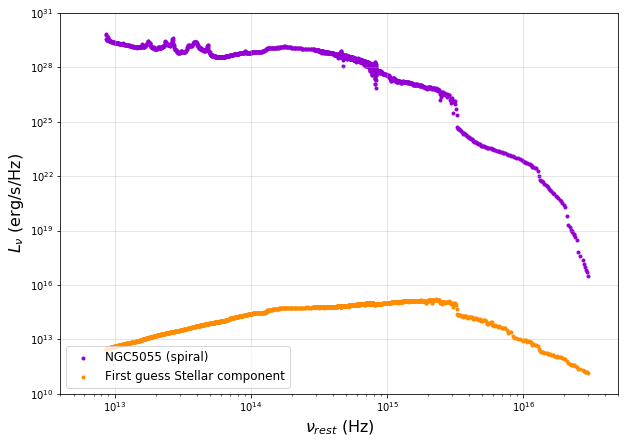

In [47]:
fig = plt.figure(figsize=(10,7))

ax = fig.add_subplot(111)
ax.scatter(df['Freq'],df['L_nu'], marker = '.',color = 'darkviolet',label = "NGC5055 (spiral)"  )
ax.scatter(model_freq, model_lumi, marker = '.',color = 'darkorange',label = "First guess Stellar component"  ) 
ax.grid(alpha=0.4)
ylims = [1e10, 1e31]
ax.set_ylim(ylims)
ax.set_yscale('log')
xlims = [4e12, 5e16]
ax.set_xlim(xlims)
ax.set_xscale('log')
ax.set_ylabel(r"$ L_{\nu}$ (erg/s/Hz)", fontsize = 16)
ax.set_xlabel(r"$\nu_{rest}$ (Hz)", fontsize = 16)
ax.legend(loc="lower left", fontsize = 12)

plt.show()

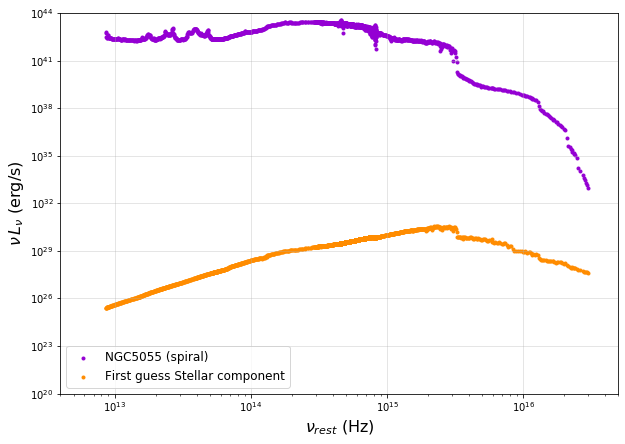

In [52]:
fig = plt.figure(figsize=(10,7))

ax = fig.add_subplot(111)
ax.scatter(df['Freq'], df['Freq']*df['L_nu'], marker = '.',color = 'darkviolet',label = "NGC5055 (spiral)"  )
ax.scatter(model_freq, model_freq*model_lumi, marker = '.',color = 'darkorange',label = "First guess Stellar component"  ) 
ax.grid(alpha=0.4)
ylims = [1e20, 1e44]
ax.set_ylim(ylims)
ax.set_yscale('log')
xlims = [4e12, 5e16]
ax.set_xlim(xlims)
ax.set_xscale('log')
ax.set_ylabel(r"$\nu \, L_{\nu}$ (erg/s)", fontsize = 16)
ax.set_xlabel(r"$\nu_{rest}$ (Hz)", fontsize = 16)
ax.legend(loc="lower left", fontsize = 12)

plt.show()

Ok, μάλλον έχω κάνει λάθος στην κανονικοποίηση των template σε ηλιακή μάζα. 
Το ανεβάζω προσωρινά έτσι για να πιάσουμε το νόημα και θα το διορθώσω όταν διαβάσω προσεκτικότερα την φόρμουλα με την οποία παράχθηκαν.

# 02. $\chi^2$ minimisation για να βρούμε το καλύτερο template με το καλύτερο scaling μάζας που αναπαριστά με έναν αστρικό πληθυσμό τον γαλαξία μας. 

In [56]:
%%time

errs = 1e15*np.ones(len(df['Freq'])) #arbitrary

masses = 10**np.arange(9, 13, 0.2)  # μεταξύ 10^9 και 10^13
templ_indices = np.arange(len(list(GALAXY_dict.keys())))

best_chisq = np.inf
best_point = [0.,0.]

n_masses = masses.shape[0]
n_temps = templ_indices.shape[0]
n_models = n_masses*n_temps 

for j in range(n_masses):
    for k in range(n_temps):    
        model_no = k + j*n_masses
            
        if not model_no % 10000:
            print("Tried", model_no, "/", n_models, "models.")
            
        mass = masses[j]
        templ_idx = templ_indices[k]
        
        nu_temp = GALAXY_dict[list(GALAXY_dict.keys())[templ_idx]][0]
        F_nu_temp = GALAXY_dict[list(GALAXY_dict.keys())[templ_idx]][1]

        model_freq = df['Freq'].copy().to_numpy()
        model_lumi = np.interp(df['Freq'].copy().to_numpy(),nu_temp,F_nu_temp,left=0, right=0)
        model_lumi *=mass
                    
        diffs = df['L_nu'] - model_lumi

        chisq = np.sum(diffs**2/errs**2)
            
        if chisq < best_chisq:
                best_chisq = chisq
                best_point = [j,k]
                
print("best chi-squared value:", best_chisq)
print("best parameters (log mass, no of template):",
       np.log10(masses[best_point[0]]),
       [best_point[1]])

Tried 0 / 672000 models.
best chi-squared value: 1.4480879995809647e+31
best parameters (log mass, no of template): 12.799999999999986 [0]
CPU times: user 15min 42s, sys: 371 ms, total: 15min 43s
Wall time: 15min 43s
